In [1]:
# Importing the libraries
import folium
import itertools
import warnings
import numpy as np
import pandas as pd
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Setting up display format
pd.options.display.float_format = "{:,.2f}".format


In [2]:
# Defining modeling functions

# Flattening and Grouping the DataFrame
def flat_df(df, name, state, id_vars = ('CountyName', 'State'), cols = '1996-04'):
    flat = pd.melt(df, id_vars = id_vars, value_vars = df[cols], var_name = 'Date', value_name = 'Actual Data')
    flat['Date'] = pd.to_datetime(flat['Date'], format = '%Y-%m')
    flat = flat.set_index('Date')
    flat = flat.loc[(flat['CountyName'] == name) & (flat['State'] == state)]
    group_df = flat.groupby(['Date']).median()
    return group_df


# Time Series Train-Test Split - using a 75-25% rule
def ts_train_test(df):
    size = int(round(len(df)*.25, 0))
    train = df[:-size].asfreq('MS')
    test = df[-size:].asfreq('MS')
    return train, test

# Defining a function for ACF and PACF plots
def func_plot(dataframe):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,8))
    plot_acf(dataframe, ax = ax1, lags = 12)
    plot_pacf(dataframe, ax = ax2, lags = 12)
    plt.show()
    
# Seasonal Decomposition - inspired by Flatiron School's 
# https://github.com/flatiron-school/ds-time_series_modeling_walkthrough-gfc33
def seas_dec(df):
    p = d = q = range(0,2)
    train = ts_train_test(df)[0]
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
   
    aic_dict = {}
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod=SARIMAX(train,
                             order=param,
                             seasonal_order=param_seasonal,
                             enforce_stationarity=False,
                             enforce_invertibility=False)
                results = mod.fit()
                aic_dict[str(param) + 'x' + str(param_seasonal)] = round(results.aic,4)
            except: 
                continue
    aic_list = sorted(aic_dict.items(), key = lambda x: x[1])[0]
    return print('The combination of', aic_list[0], 'yields the AIC of', aic_list[1])
    
# ARMA model function with an order of p,d,q (0,0,0) x p,d,q,s (0, 0, 0, 0)
def arma_model(df, pdq = (0,0,0), pdqs = (0,0,0,0)):
    train, test = ts_train_test(df)
    model = SARIMAX(train, order = pdq, seasonal_order = pdqs)
    output = model.fit()
    residuals = output.resid
    print(output.summary())
    output.plot_diagnostics(figsize = (10, 5))
    plt.show();
    return train, test, output

def rmse_calc(df, pdq = (0,0,0), pdqs = (0,0,0,0), window = 24):
    train, test = ts_train_test(df) 
    model = SARIMAX(train, order = pdq, seasonal_order = pdqs)
    output = model.fit()
    y_hat = output.predict(-window)
    mse = round(np.sqrt(mean_squared_error(train[-window:], y_hat)), 4)
    plt.figure(figsize = (10, 5))
    plt.title('Training Data and Predicted Data')
    plt.plot(train[-2 * window:], label = 'Training Data')
    plt.plot(y_hat, label = 'Predicted Data')
    plt.legend()
    plt.show()
    print(f'RMSE: {mse}')
    
def forecast_func(df, pdq = (0,0,0), pdqs = (0,0,0,0), window = 24):
    # Function adapted from
    # https://analyticsindiamag.com/complete-guide-to-sarimax-in-python-for-time-series-modeling/
    model = SARIMAX(df, order = pdq, seasonal_order = pdqs)
    output = model.fit()
    
    # Getting fitted values
    fc = pd.date_range(df.index[-1] + pd.DateOffset(months=1), periods = window, freq = 'MS')
    fc = pd.DataFrame(index = fc[1:], columns = df.columns)
    aux_df = pd.concat([df, fc])
    aux_df['Forecast'] = output.predict(start = df.index[-1], end = aux_df.index[-1], dynamic = True)
     
    # Plotting
    aux_df.plot(figsize = (15, 8));
    plt.title(f'Forecasting {window} periods')
    
    
    



In [3]:
# Importing the Zillow dataset
data = pd.read_csv('csv/zillow_data.csv')

# Retrieve the first 5 rows
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,"334,200.00","335,400.00","336,500.00",...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,"235,700.00","236,900.00","236,700.00",...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,"210,400.00","212,200.00","212,200.00",...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,"498,100.00","500,900.00","503,100.00",...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,"77,300.00","77,300.00","77,300.00",...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# Dropping NAs
data = data.dropna()

# Columns to Remove when performing calculations
cat_col = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']

# We will use this to filter later
data_col = list(data.columns)

# Removing Categorical Variables
for col in cat_col:
     data_col.remove(col)


In [5]:
# Retrieving Top 5 Metro areas
data['Metro'].value_counts(ascending = False, normalize = True)[:5]


New York                         0.06
Los Angeles-Long Beach-Anaheim   0.03
Chicago                          0.02
Philadelphia                     0.02
Washington                       0.02
Name: Metro, dtype: float64

In [6]:
# Retrieving Top 5 Cities
data['City'].value_counts(ascending = False, normalize = True)[:5]

New York      0.01
Los Angeles   0.01
Houston       0.01
San Antonio   0.00
Washington    0.00
Name: City, dtype: float64

In [7]:
# Retrieving Top 5 County
data['CountyName'].value_counts(ascending = False, normalize = True)[:5]

Los Angeles   0.02
Jefferson     0.01
Orange        0.01
Washington    0.01
Montgomery    0.01
Name: CountyName, dtype: float64

In [8]:
# Describing our Dataset, without the categorical features
data[data_col].describe()

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,"12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00",...,"12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00","12,895.00"
mean,"121,203.58","121,327.06","121,449.02","121,568.36","121,699.39","121,851.42","122,050.20","122,281.55","122,631.00","123,078.83",...,"286,636.68","288,292.95","290,050.15","291,772.68","293,396.42","295,114.26","296,821.83","298,687.96","301,031.61","302,709.84"
std,"87,295.61","87,453.86","87,612.46","87,776.32","87,965.17","88,193.06","88,480.98","88,818.47","89,262.76","89,771.67",...,"310,175.26","312,378.06","314,942.48","317,665.58","320,034.99","322,583.32","325,328.07","327,981.37","330,770.19","332,485.34"
min,"11,400.00","11,500.00","11,600.00","11,800.00","11,800.00","12,000.00","12,100.00","12,200.00","12,300.00","12,500.00",...,"14,400.00","14,500.00","14,700.00","14,800.00","14,500.00","14,300.00","14,100.00","13,900.00","13,800.00","13,800.00"
25%,"71,200.00","71,400.00","71,600.00","71,700.00","71,800.00","71,900.00","72,100.00","72,300.00","72,500.00","72,900.00",...,"135,800.00","136,600.00","137,400.00","138,150.00","138,650.00","139,200.00","139,700.00","140,100.00","141,000.00","141,800.00"
50%,"102,200.00","102,300.00","102,300.00","102,400.00","102,500.00","102,500.00","102,700.00","102,900.00","103,100.00","103,500.00",...,"201,200.00","202,500.00","203,700.00","205,200.00","206,400.00","207,600.00","208,500.00","209,800.00","211,500.00","213,000.00"
75%,"145,800.00","145,900.00","146,000.00","146,100.00","146,100.00","146,300.00","146,300.00","146,600.00","147,100.00","147,600.00",...,"325,100.00","326,600.00","328,200.00","330,050.00","331,750.00","333,800.00","335,700.00","337,700.00","340,550.00","342,200.00"
max,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00","3,813,500.00","3,849,600.00","3,888,900.00","3,928,800.00","3,964,600.00",...,"7,410,100.00","7,422,400.00","7,417,600.00","7,427,300.00","7,371,400.00","7,342,700.00","7,353,300.00","7,350,300.00","7,363,000.00","7,386,600.00"


In [9]:
# Calculating historical median, average and std. deviation
data['median'] = data[data_col].median(axis = 1)
data['average'] = data[data_col].mean(axis = 1)
data['std'] = data[data_col].std(axis = 1)

In [10]:
# Top Median CountyNames
med_county = data.groupby(['CountyName', 'State']).max('median').sort_values('median', ascending = False).reset_index()[:10]
med_county

,CountyName,State,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,median,average,std
0,New York,NY,62009,11106,1066,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00",...,7427300,7371400,7342700,7353300,7350300,7363000,7386600,"5,190,800.00","5,085,435.85","1,470,203.86"
1,San Mateo,CA,97704,94404,12605,"1,179,200.00","1,184,300.00","1,189,700.00","1,195,400.00","1,201,200.00",...,6315400,6429100,6581800,6705000,6764600,6788400,6796500,"3,506,200.00","3,487,129.06","1,296,223.81"
2,Pitkin,CO,93846,81654,14137,"1,458,200.00","1,453,700.00","1,464,300.00","1,475,000.00","1,485,800.00",...,4193900,4244400,4321700,4381800,4469700,4626100,4766600,"3,268,700.00","3,147,124.15","895,536.33"
3,Palm Beach,FL,399574,33498,8902,"958,400.00","958,100.00","957,900.00","957,800.00","958,000.00",...,4583200,4588200,4609000,4626500,4661200,4692300,4686200,"2,682,500.00","2,634,498.11","1,007,004.81"
4,Los Angeles,CA,399675,93552,14673,"1,015,400.00","1,016,900.00","1,018,400.00","1,019,800.00","1,021,400.00",...,5503000,5574100,5661000,5738200,5816100,5907800,5956700,"2,598,900.00","2,789,977.36","1,222,910.25"
5,San Francisco,CA,97588,94134,5798,"849,100.00","859,000.00","868,800.00","878,400.00","887,800.00",...,4598200,4596300,4579000,4582000,4597600,4640200,4682300,"2,551,500.00","2,630,977.36","987,297.73"
6,Bergen,NJ,60754,7677,13901,"1,075,400.00","1,075,900.00","1,076,500.00","1,077,100.00","1,077,700.00",...,3092700,3077500,3047100,3054800,3061200,3060700,3069100,"2,282,900.00","2,080,074.34","620,753.09"
7,San Diego,CA,96707,92173,13886,"991,000.00","994,700.00","998,400.00","1,002,300.00","1,006,200.00",...,2861500,2864900,2868600,2882000,2893300,2886800,2870800,"2,199,900.00","2,170,121.89","543,539.13"
8,Orange,CA,97079,92887,13835,"706,900.00","710,700.00","714,700.00","718,700.00","723,100.00",...,3305800,3319500,3342300,3367000,3380800,3387400,3393400,"2,129,600.00","2,070,006.04","751,164.50"
9,Suffolk,NY,62324,11980,14536,"455,000.00","454,200.00","453,400.00","452,700.00","452,200.00",...,3298600,3315100,3317200,3353000,3425000,3473300,3467800,"2,107,300.00","1,803,404.15","794,463.61"


In [11]:
# Top Average CountyNames
avg_county = data.groupby(['CountyName', 'State']).max('average').sort_values('average', ascending = False).reset_index()[:10]
avg_county

,CountyName,State,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,median,average,std
0,New York,NY,62009,11106,1066,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00",...,7427300,7371400,7342700,7353300,7350300,7363000,7386600,"5,190,800.00","5,085,435.85","1,470,203.86"
1,San Mateo,CA,97704,94404,12605,"1,179,200.00","1,184,300.00","1,189,700.00","1,195,400.00","1,201,200.00",...,6315400,6429100,6581800,6705000,6764600,6788400,6796500,"3,506,200.00","3,487,129.06","1,296,223.81"
2,Pitkin,CO,93846,81654,14137,"1,458,200.00","1,453,700.00","1,464,300.00","1,475,000.00","1,485,800.00",...,4193900,4244400,4321700,4381800,4469700,4626100,4766600,"3,268,700.00","3,147,124.15","895,536.33"
3,Los Angeles,CA,399675,93552,14673,"1,015,400.00","1,016,900.00","1,018,400.00","1,019,800.00","1,021,400.00",...,5503000,5574100,5661000,5738200,5816100,5907800,5956700,"2,598,900.00","2,789,977.36","1,222,910.25"
4,Palm Beach,FL,399574,33498,8902,"958,400.00","958,100.00","957,900.00","957,800.00","958,000.00",...,4583200,4588200,4609000,4626500,4661200,4692300,4686200,"2,682,500.00","2,634,498.11","1,007,004.81"
5,San Francisco,CA,97588,94134,5798,"849,100.00","859,000.00","868,800.00","878,400.00","887,800.00",...,4598200,4596300,4579000,4582000,4597600,4640200,4682300,"2,551,500.00","2,630,977.36","987,297.73"
6,San Diego,CA,96707,92173,13886,"991,000.00","994,700.00","998,400.00","1,002,300.00","1,006,200.00",...,2861500,2864900,2868600,2882000,2893300,2886800,2870800,"2,199,900.00","2,170,121.89","543,539.13"
7,Santa Clara,CA,98011,95148,10656,"795,600.00","798,400.00","801,700.00","805,400.00","809,600.00",...,4401100,4481700,4544700,4595100,4668700,4762600,4818400,"1,890,300.00","2,084,380.38","974,592.78"
8,Bergen,NJ,60754,7677,13901,"1,075,400.00","1,075,900.00","1,076,500.00","1,077,100.00","1,077,700.00",...,3092700,3077500,3047100,3054800,3061200,3060700,3069100,"2,282,900.00","2,080,074.34","620,753.09"
9,Orange,CA,97079,92887,13835,"706,900.00","710,700.00","714,700.00","718,700.00","723,100.00",...,3305800,3319500,3342300,3367000,3380800,3387400,3393400,"2,129,600.00","2,070,006.04","751,164.50"


In [12]:
# Top 10 Std Counties
std_county = data.groupby(['CountyName', 'State']).max('std').sort_values('std', ascending = False).reset_index()[:10]
std_county

,CountyName,State,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,median,average,std
0,New York,NY,62009,11106,1066,"3,676,700.00","3,704,200.00","3,729,600.00","3,754,600.00","3,781,800.00",...,7427300,7371400,7342700,7353300,7350300,7363000,7386600,"5,190,800.00","5,085,435.85","1,470,203.86"
1,San Mateo,CA,97704,94404,12605,"1,179,200.00","1,184,300.00","1,189,700.00","1,195,400.00","1,201,200.00",...,6315400,6429100,6581800,6705000,6764600,6788400,6796500,"3,506,200.00","3,487,129.06","1,296,223.81"
2,Los Angeles,CA,399675,93552,14673,"1,015,400.00","1,016,900.00","1,018,400.00","1,019,800.00","1,021,400.00",...,5503000,5574100,5661000,5738200,5816100,5907800,5956700,"2,598,900.00","2,789,977.36","1,222,910.25"
3,Palm Beach,FL,399574,33498,8902,"958,400.00","958,100.00","957,900.00","957,800.00","958,000.00",...,4583200,4588200,4609000,4626500,4661200,4692300,4686200,"2,682,500.00","2,634,498.11","1,007,004.81"
4,San Francisco,CA,97588,94134,5798,"849,100.00","859,000.00","868,800.00","878,400.00","887,800.00",...,4598200,4596300,4579000,4582000,4597600,4640200,4682300,"2,551,500.00","2,630,977.36","987,297.73"
5,Santa Clara,CA,98011,95148,10656,"795,600.00","798,400.00","801,700.00","805,400.00","809,600.00",...,4401100,4481700,4544700,4595100,4668700,4762600,4818400,"1,890,300.00","2,084,380.38","974,592.78"
6,Pitkin,CO,93846,81654,14137,"1,458,200.00","1,453,700.00","1,464,300.00","1,475,000.00","1,485,800.00",...,4193900,4244400,4321700,4381800,4469700,4626100,4766600,"3,268,700.00","3,147,124.15","895,536.33"
7,Suffolk,NY,62324,11980,14536,"455,000.00","454,200.00","453,400.00","452,700.00","452,200.00",...,3298600,3315100,3317200,3353000,3425000,3473300,3467800,"2,107,300.00","1,803,404.15","794,463.61"
8,Orange,CA,97079,92887,13835,"706,900.00","710,700.00","714,700.00","718,700.00","723,100.00",...,3305800,3319500,3342300,3367000,3380800,3387400,3393400,"2,129,600.00","2,070,006.04","751,164.50"
9,Miami-Dade,FL,72497,33196,10767,"602,700.00","603,600.00","604,600.00","605,800.00","607,200.00",...,3017700,3006400,2999800,3011100,2993200,2933600,2914100,"1,502,900.00","1,611,726.79","732,706.97"


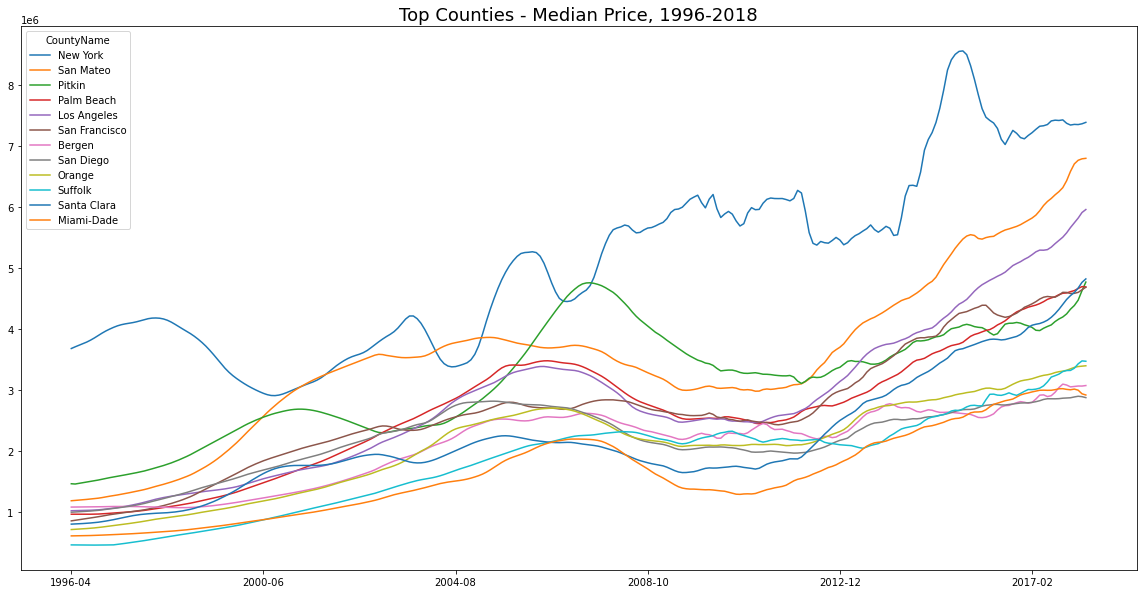

In [13]:
# List of Top Counties
county_list = list(set(list(med_county['CountyName']) + list(avg_county['CountyName']) + \
                       list(std_county['CountyName'])))

# Filtering for Top Counties and removing columns that we don't need
df = data[data['CountyName'].isin(county_list) == True]
df = df.loc[:, ~df.columns.isin(['RegionID', 'RegionName', 'SizeRank', 'Metro'])]

# Ordering before reshaping
county_group = df.groupby('CountyName').max('median').sort_values(by = 'median', ascending = False)

# Reshaping for Plotting the Time Series
county_long = county_group.T.iloc[:-3]

# Plotting the graph - Top Counties - Median Price, 1996-2018
county_long.plot(figsize=(20,10))
plt.title('Top Counties - Median Price, 1996-2018', fontsize = 18);

In [14]:
# Country-state list
county_state_list = set(list(df['City'] + ', ' + df['State']))

# Initialize Nominatim API
geolocator = Nominatim(user_agent="MyApp")

# Creating a dictionary to parse latitude and longitude
dict_val = {}
for val in list(county_state_list):
    try:
        location = geolocator.geocode(val)
        dict_val[val] = (location.latitude, location.longitude)
    except Exception:
        continue


In [15]:
# United States Map
m = folium.Map(location=[39, -95], zoom_start = 4, width = 800, height = 500)

# Removing Silverado - CA, Half Moon Bay - CA, Placentia - CA, and Monroe - NY - geocoordinates not working properly
del dict_val['Silverado, CA']
del dict_val['Half Moon Bay, CA']
del dict_val['Placentia, CA']
del dict_val['Monroe, NY']

# Marking our top locations on the US map
for key, val in dict_val.items():
    folium.Marker([dict_val[key][0], dict_val[key][1]], popup=key).add_to(m)

In [16]:
# Plotting our US map
m

In [17]:
# Preparing the DataFrame for rolling statistics
county_rol = df.groupby('CountyName').max('average').sort_values(by = 'average', ascending = False)

# Reshaping the Time Series
county_rol_long = county_rol.T.iloc[:-3]

# County List Rolling Statistics calculation
stat_dict = {}
for county in county_list:
    # The first value of each key is the mean (index 0), the second is the rolling mean (index 1),
    # the third is the rolling std deviation (index 2). The rolling stats use a 12-month window
    stat_dict[county] = (county_rol_long[county], county_rol_long[county].rolling(window = 12, center = False).mean(),\
                         county_rol_long[county].rolling(window = 12, center = False).std()) 


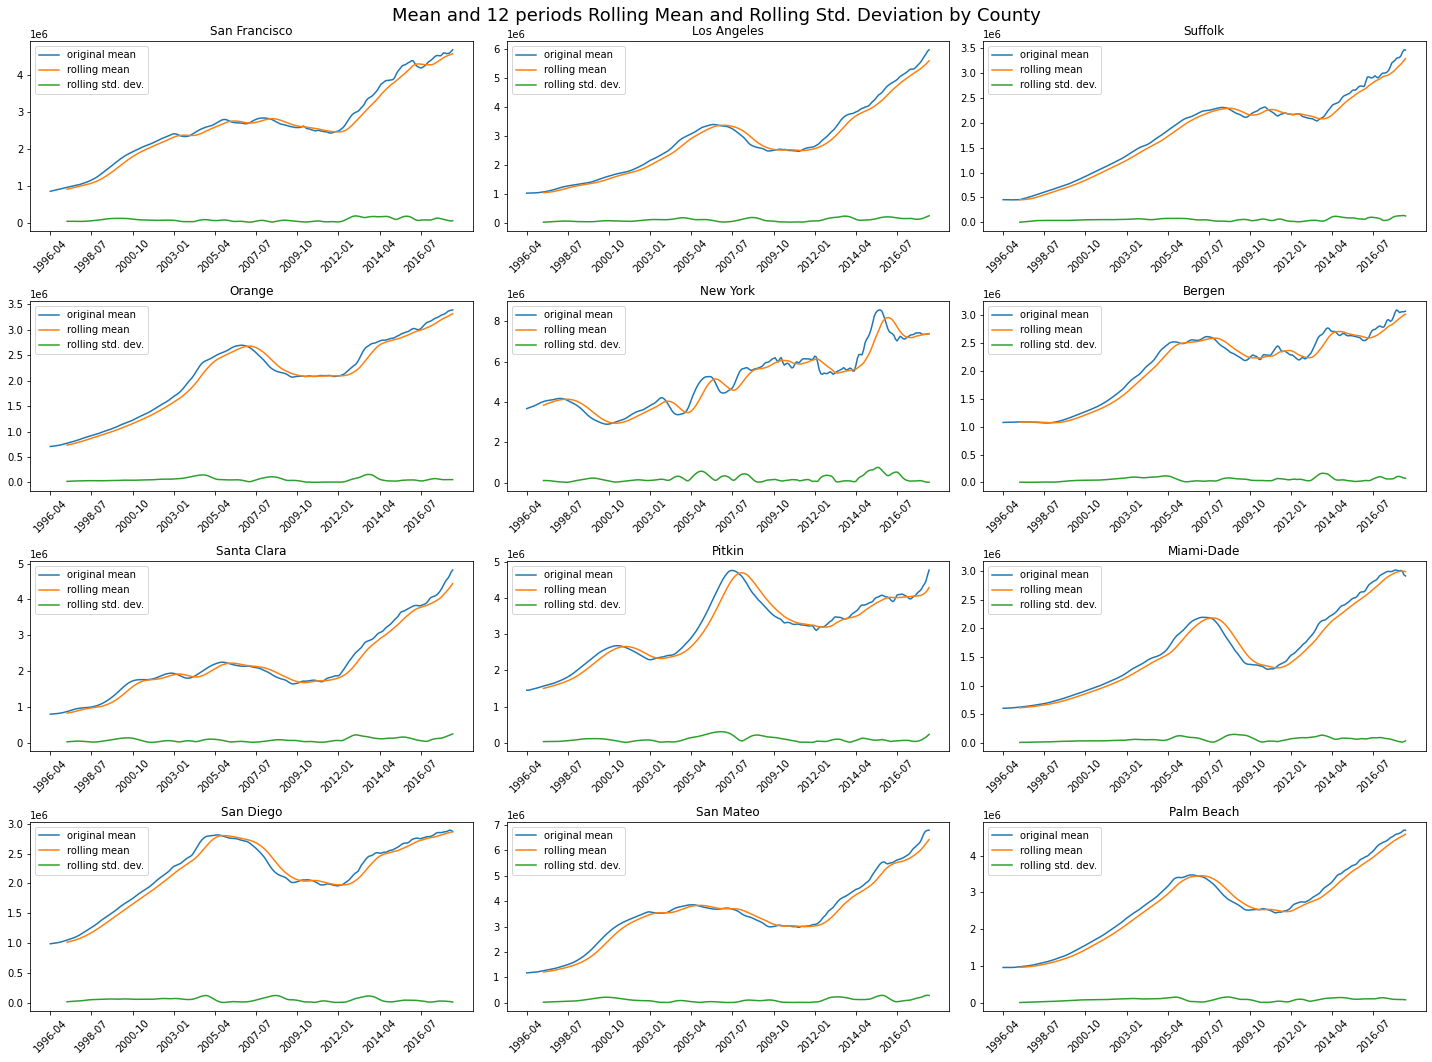

In [18]:
# Plotting rolling stats by county
fig, ax = plt.subplots(4,3, figsize = (20,15))
for count, val in enumerate(stat_dict):
    ax[count // 3][count % 3].plot(stat_dict[val][0], label = 'original mean')
    ax[count // 3][count % 3].plot(stat_dict[val][1], label = 'rolling mean')
    ax[count // 3][count % 3].plot(stat_dict[val][2], label = 'rolling std. dev.')
    ax[count // 3][count % 3].set_title(val)
    ax[count // 3][count % 3].legend()
    ax[count // 3][count % 3].set_xticks(county_rol_long.reset_index()['index'])
    ax[count // 3][count % 3].set_xticklabels(county_rol_long.reset_index()['index'], rotation = 45)
    ax[count // 3][count % 3].locator_params(axis="x", nbins=10, tight = True)
    fig.suptitle('Mean and 12 periods Rolling Mean and Rolling Std. Deviation by County', fontsize = 18)
    plt.tight_layout();

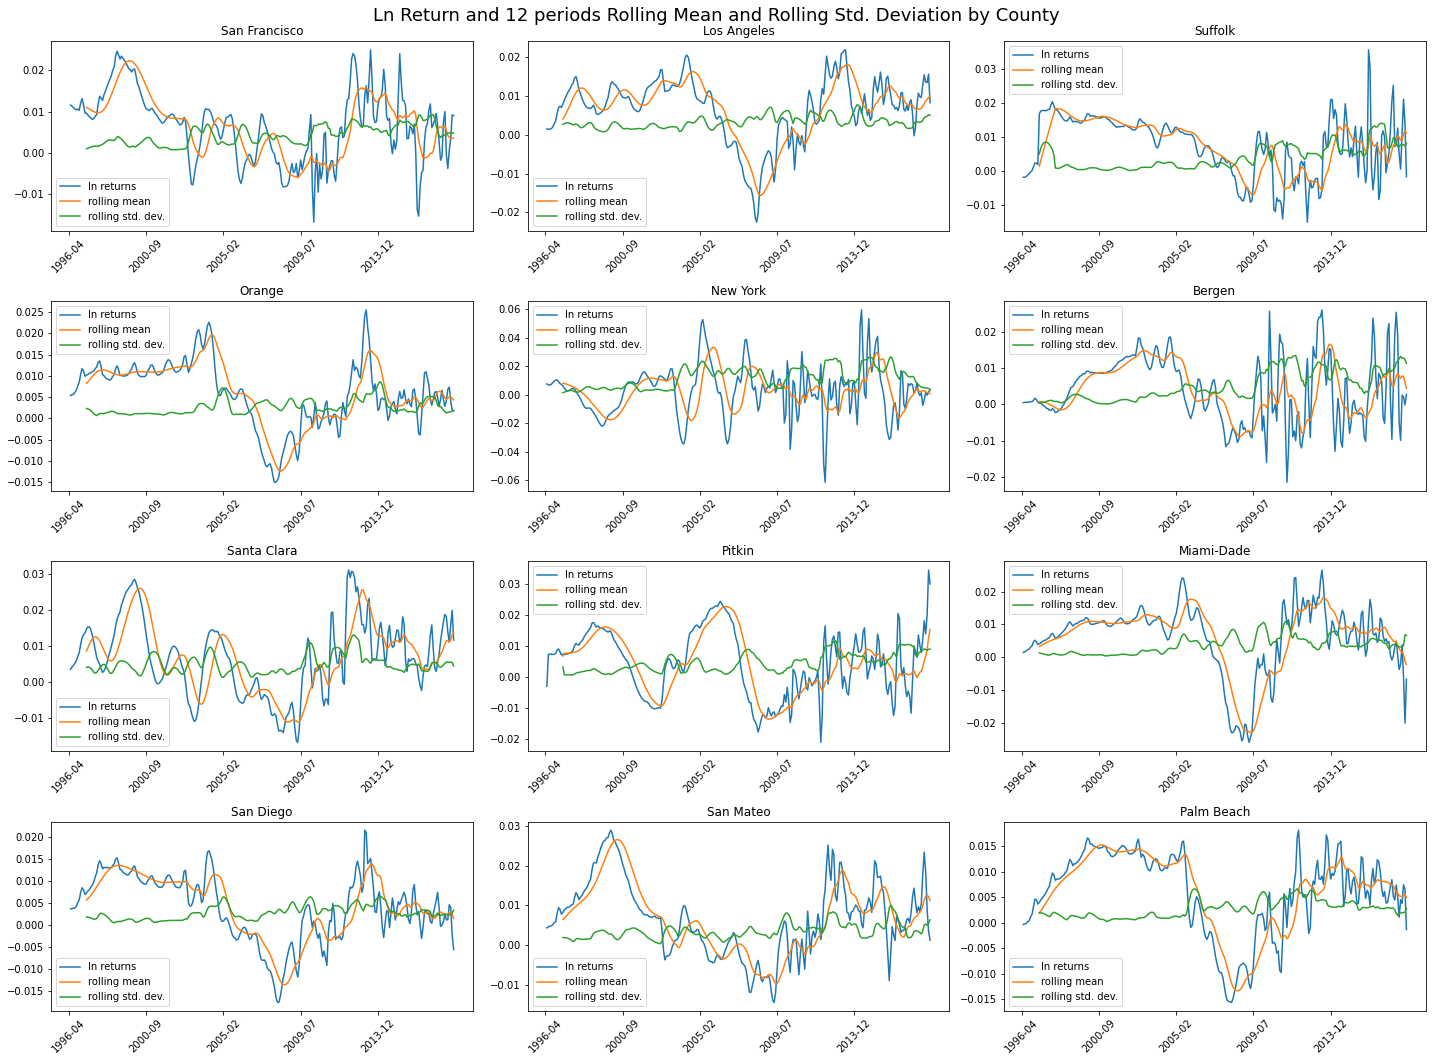

In [19]:
# Creating a dict of returns, I'll generate specific DataFrames to isolate each county
ret_dict = {}
for county in county_list:
    # The first value is the ln return (index 0), the second is the rolling 12-month average (index 1),
    # the third one is the 12-month std. deviation (index 2)
    aux_df = pd.DataFrame(county_rol_long[county])
    aux_df['shift'] = county_rol_long[county].shift(1)
    aux_df['ln ret'] = np.log(aux_df[county] / aux_df['shift'] )
    ret_dict[county] = (aux_df['ln ret'], aux_df['ln ret'].rolling(window = 12, center = False).mean(), \
                        aux_df['ln ret'].rolling(window = 12, center = False).std())

# Plotting the returns on a Graph
fig, ax = plt.subplots(4,3, figsize = (20,15))
for count, val in enumerate(ret_dict):
    ax[count // 3][count % 3].plot(ret_dict[val][0], label = 'ln returns')
    ax[count // 3][count % 3].plot(ret_dict[val][1], label = 'rolling mean')
    ax[count // 3][count % 3].plot(ret_dict[val][2], label = 'rolling std. dev.')
    ax[count // 3][count % 3].set_title(val)
    ax[count // 3][count % 3].legend()
    ax[count // 3][count % 3].set_xticks(aux_df.reset_index()['index'])
    ax[count // 3][count % 3].set_xticklabels(aux_df.reset_index()['index'], rotation = 45)
    ax[count // 3][count % 3].locator_params(axis="x", nbins=5, tight = True)
    fig.suptitle('Ln Return and 12 periods Rolling Mean and Rolling Std. Deviation by County', fontsize = 18)
    plt.tight_layout();


In [20]:
# Calculating risk-weighted return. First entry is the risk weighted return
wtd_ret = {}
for county in county_list:
    aux_df = pd.DataFrame(county_rol_long[county])
    aux_df['shift'] = county_rol_long[county].shift(1)
    aux_df['ln ret'] = np.log(aux_df[county] / aux_df['shift'] )
    aux_df['risk wtd'] = aux_df['ln ret'].rolling(12).mean() / aux_df['ln ret'].rolling(12).std()
    wtd_ret[county] = aux_df['risk wtd']

In [21]:
# Wtd Return DataFrame
df_wtd = pd.DataFrame.from_dict(wtd_ret).dropna()

# Historical Risk Adj. Return
hist_ret_wtd = df_wtd.mean(axis = 0).sort_values(ascending = True)

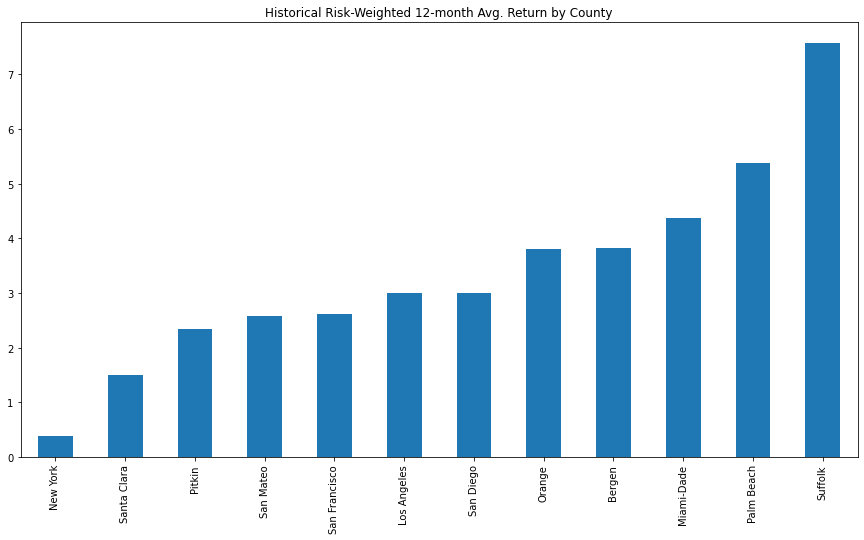

In [22]:
# Risk-Wtd Return
hist_ret_wtd.plot.bar(figsize = (15, 8))
plt.title('Historical Risk-Weighted 12-month Avg. Return by County');

In [23]:
# Working with the top three counties - Unit-Root test
for p in ['Suffolk', 'Palm Beach', 'Miami-Dade']:
    # Checking for the mean prices - using the same dict as before
    df_test = pd.DataFrame(stat_dict[p][1]).dropna()
    adftest = adfuller(df_test)
    count = 0
    print(p + ' ADF test:')
    print('======================')
    if adftest[1] >= 0.05:
        while adftest[1] >= 0.05:
            print(count, 'Difference(s).')
            print('p-value: ', round(adftest[1],4))
            print('-Fail to reject H0.\n')
            df_test = df_test.diff().dropna()
            adftest = adfuller(df_test)
            count +=1
        else:
            print(count, 'Difference(s)')
            print('-H0 is rejected.\n')

Suffolk ADF test:
0 Difference(s).
p-value:  0.9146
-Fail to reject H0.

1 Difference(s).
p-value:  0.2779
-Fail to reject H0.

2 Difference(s)
-H0 is rejected.

Palm Beach ADF test:
0 Difference(s).
p-value:  0.6805
-Fail to reject H0.

1 Difference(s).
p-value:  0.171
-Fail to reject H0.

2 Difference(s).
p-value:  0.2096
-Fail to reject H0.

3 Difference(s)
-H0 is rejected.

Miami-Dade ADF test:
0 Difference(s).
p-value:  0.708
-Fail to reject H0.

1 Difference(s)
-H0 is rejected.



In [24]:
# Preparing the DataFrames for the SARIMA models: Suffolk, Palm Beach and Miami-Dade
suffolk = flat_df(data, 'Suffolk', 'NY', ('CountyName', 'State'), data_col)

# Palm Beach
pbeach = flat_df(data, 'Palm Beach', 'FL', ('CountyName', 'State'), data_col)

# Miami-Dade
miami = flat_df(data, 'Miami-Dade', 'FL', ('CountyName', 'State'), data_col)

In [25]:
# Seasonal Decomposition and ARIMA factors check - Suffolk
# This might take some time to run, be patient!
pdq_pdqs_1 = seas_dec(suffolk) # (1,1,1) x (1, 1, 1, 12)


/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The combination of (1, 1, 1)x(1, 1, 1, 12) yields the AIC of 3066.5256


In [26]:
# Seasonal Decomposition and ARIMA factors check - Palm Beach
# This might take some time to run, be patient!
pdq_pdqs_2 = seas_dec(pbeach) # (1,1,1) x (0,1,1,12)

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

The combination of (1, 1, 1)x(0, 1, 1, 12) yields the AIC of 2718.3062


/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [27]:
# Seasonal Decomposition and ARIMA factors check - Miami-Dade
# This might take some time to run, be patient!
pdq_pdqs_3 = seas_dec(miami) # (1, 1, 1) x (1, 1, 1, 12)

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum 

The combination of (1, 1, 1)x(1, 1, 1, 12) yields the AIC of 2835.373


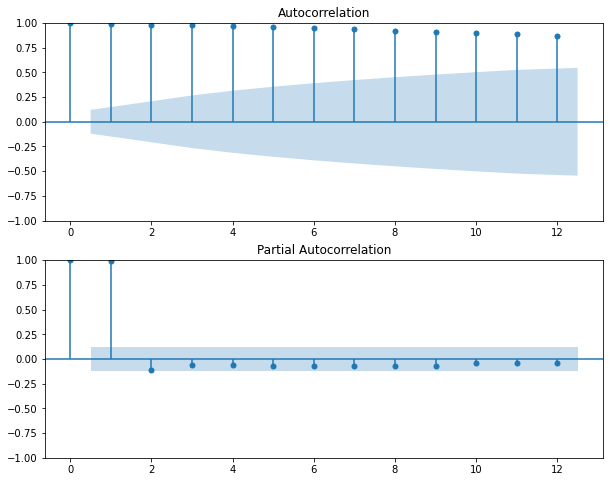

In [28]:
# Suffolk ACF and PCF
func_plot(suffolk)

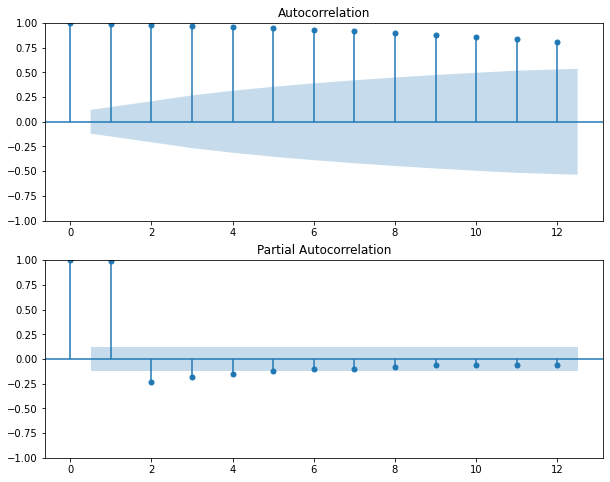

In [29]:
# Palm Beach ACF and PACF
func_plot(pbeach)

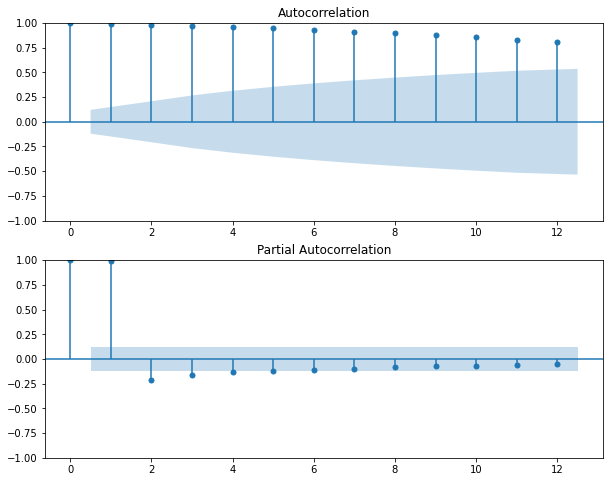

In [30]:
# Miami-Dade ACF and PACF
func_plot(miami)

/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/orlandovilar/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


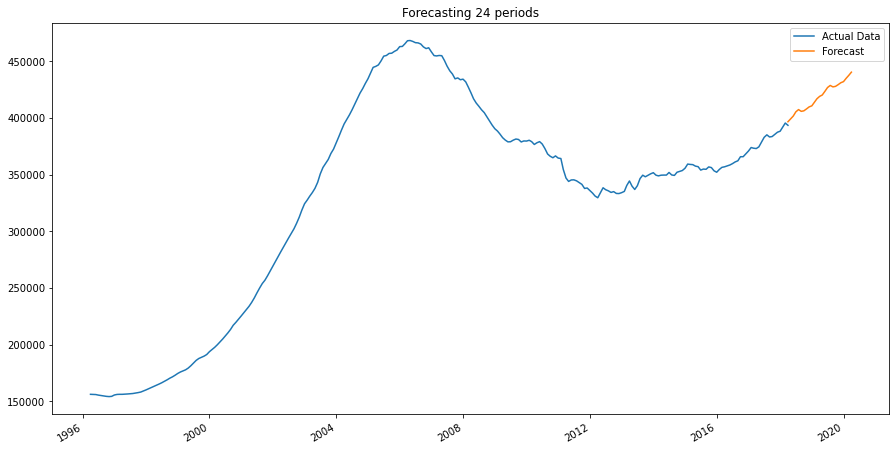

In [31]:
forecast_func(suffolk, (2, 1, 2), (1, 1, 2, 12))

In [32]:
# Delving deeper into Suffolk, NY
df_within = df[(df['CountyName'] == 'Suffolk') & (df['State'] == 'NY')]

# Within Suffolk, NY Basic Statistics
df_within['median'] = df_within[data_col].median(axis = 1)
df_within['average'] = df_within[data_col].mean(axis = 1)
df_within['std'] = df_within[data_col].std(axis = 1)

In [33]:
df_within.groupby('City').max('median').sort_values('median', ascending = False)

,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,...,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,median,average,std
City,,,,,,,,,,,,,,,,,,,,,
Water Mill,"400,000.00","402,700.00","405,700.00","408,900.00","412,600.00","416,700.00","421,400.00","426,600.00","433,100.00","440,500.00",...,3130900,3145100,3158200,3176000,3207400,3233700,3241400,"2,107,300.00","1,803,404.15","780,974.21"
Wainscott,"349,500.00","352,100.00","354,900.00","358,100.00","361,600.00","365,800.00","370,700.00","376,600.00","383,500.00","390,900.00",...,3298600,3315100,3317200,3353000,3425000,3473300,3467800,"1,718,700.00","1,574,226.79","794,463.61"
Amagansett,"328,400.00","327,900.00","327,100.00","325,900.00","324,500.00","323,000.00","321,600.00","320,400.00","320,000.00","320,300.00",...,2942600,2976300,3008500,3051700,3099000,3132200,3141100,"1,641,800.00","1,462,924.53","732,119.79"
Bridgehampton,"313,200.00","313,000.00","312,900.00","312,700.00","312,700.00","312,900.00","313,400.00","314,300.00","315,800.00","317,400.00",...,2286300,2313600,2360700,2405000,2448400,2522200,2592100,"1,417,400.00","1,234,057.74","559,003.98"
Quogue,"312,700.00","315,200.00","317,800.00","320,200.00","322,500.00","324,700.00","326,900.00","328,900.00","331,700.00","335,400.00",...,1402000,1420800,1435200,1432500,1447100,1519100,1602300,"1,095,500.00","990,752.45","372,600.83"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ridge,"122,100.00","122,300.00","122,500.00","122,600.00","122,800.00","122,900.00","123,100.00","123,400.00","123,700.00","124,200.00",...,275000,276800,278000,279100,281600,284300,286100,"242,500.00","235,463.40","66,803.82"
Sound Beach,"110,700.00","110,800.00","110,900.00","110,900.00","110,800.00","110,700.00","110,700.00","110,700.00","110,800.00","111,000.00",...,270300,269300,267400,267100,267300,267700,268600,"240,600.00","228,835.85","68,463.20"
Wyandanch,"122,700.00","121,700.00","120,700.00","119,700.00","118,700.00","117,900.00","117,100.00","116,400.00","115,800.00","115,400.00",...,246500,249300,254300,260900,260100,250900,243600,"211,000.00","209,408.30","64,162.47"
